In [1]:
# --- Celda 1: Carga y Preparación de Datos Comparativos ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- CARGANDO DATOS PARA COMPARACIÓN FEM vs. FDM ---")

try:
    df_fem = pd.read_csv('Poisson_FEM/resultados_benchmark.csv')
    df_fdm = pd.read_csv('Poisson_FDM/resultados_fdm.csv')
    
    # Añadir una columna para identificar el método
    df_fem['metodo'] = 'FEM'
    df_fdm['metodo'] = 'FDM'
    
    # Combinar ambos dataframes en uno solo
    df_total = pd.concat([df_fem, df_fdm], ignore_index=True)
    df_total['malla_total'] = df_total['malla_M'] * df_total['malla_M']
    
    print("Datos cargados y combinados con éxito.")
    
except FileNotFoundError as e:
    print(f"ERROR: No se pudo encontrar un archivo de resultados. Asegúrate de que ambos benchmarks se hayan ejecutado. Detalle: {e}")
    df_total = None



--- CARGANDO DATOS PARA COMPARACIÓN FEM vs. FDM ---
Datos cargados y combinados con éxito.


Comparando versiones paralelas con 16 hilos.


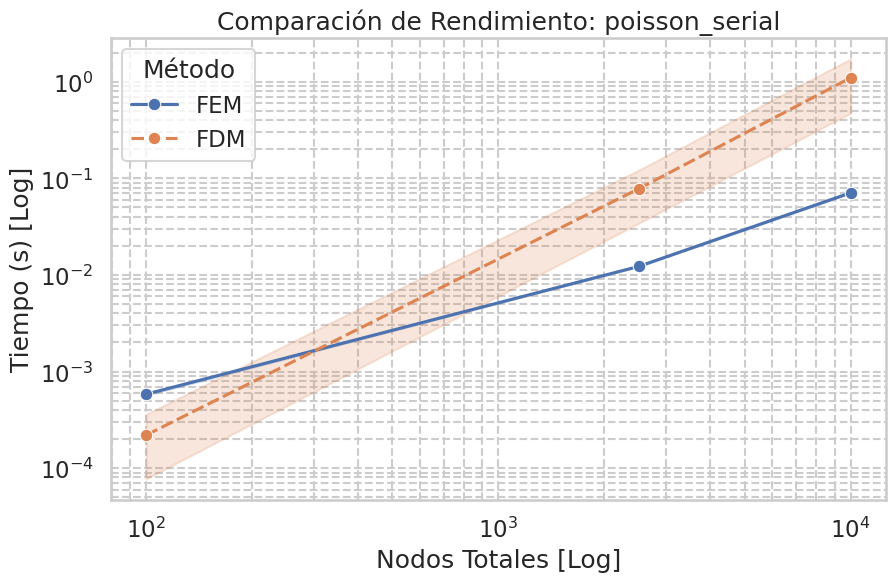

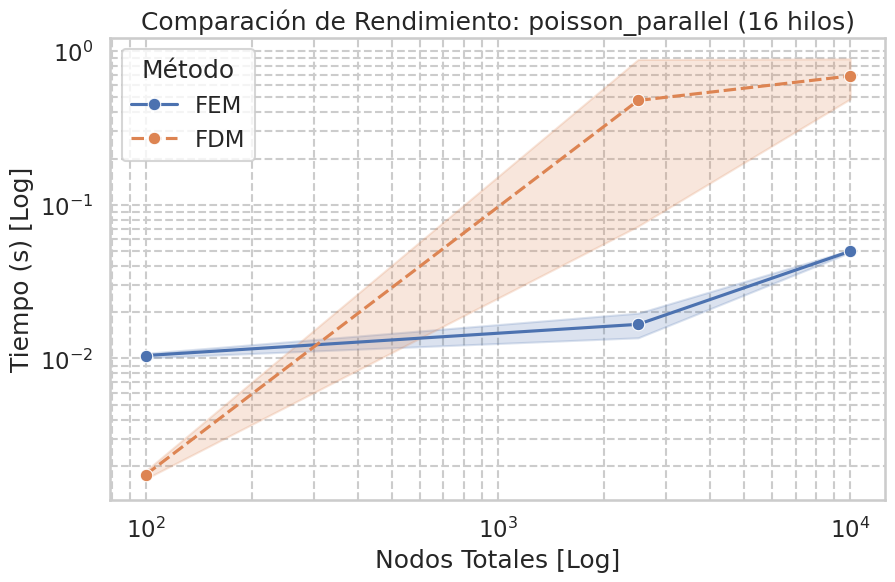

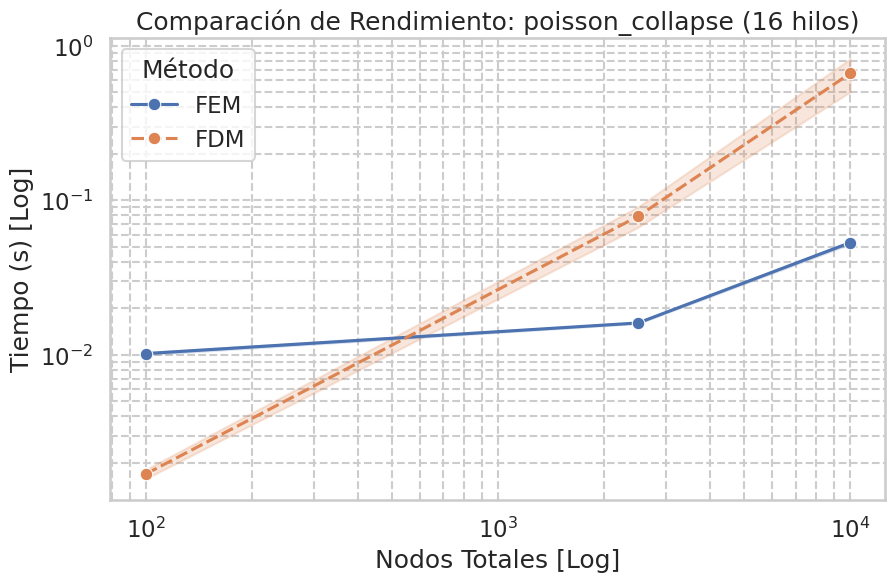

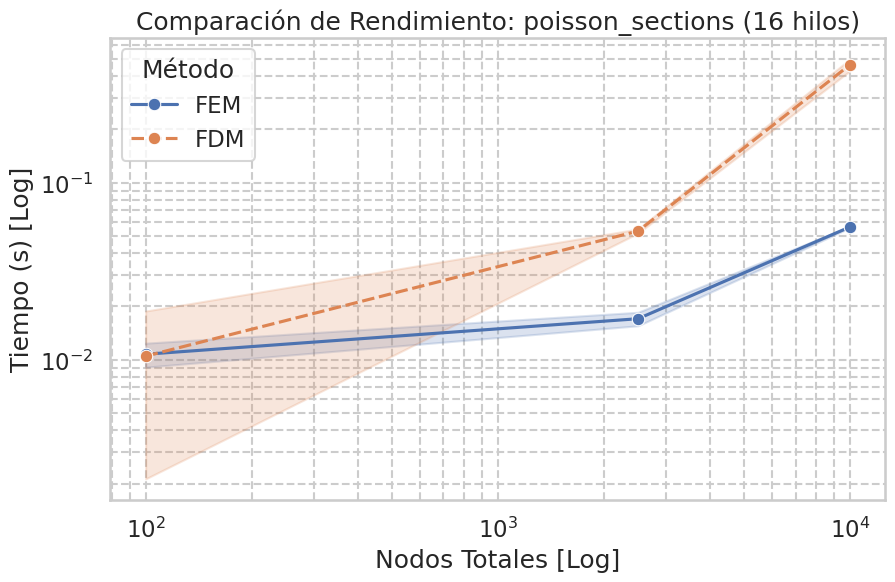

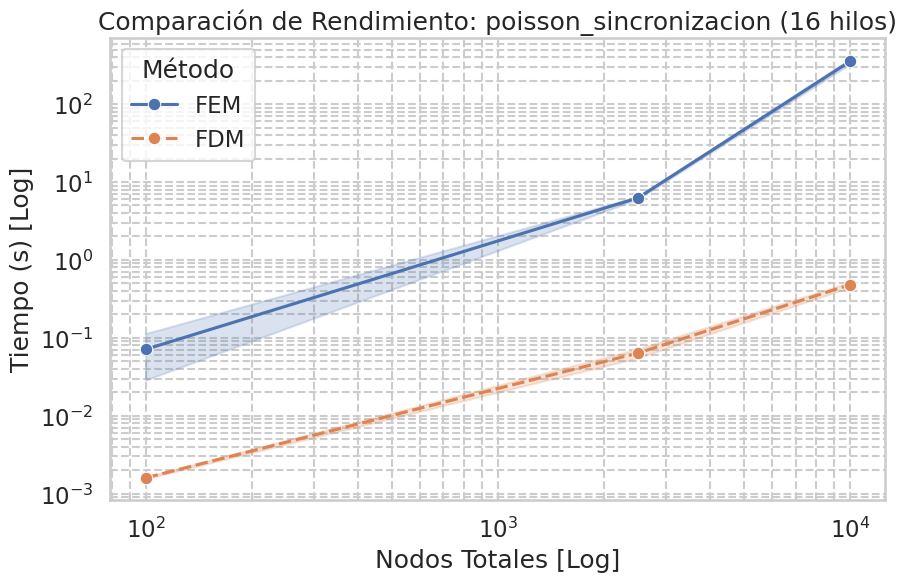

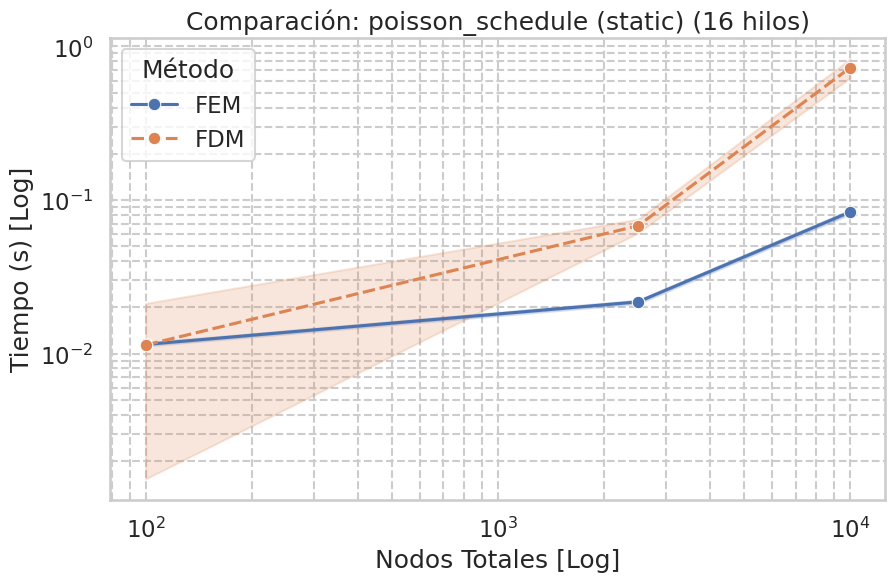

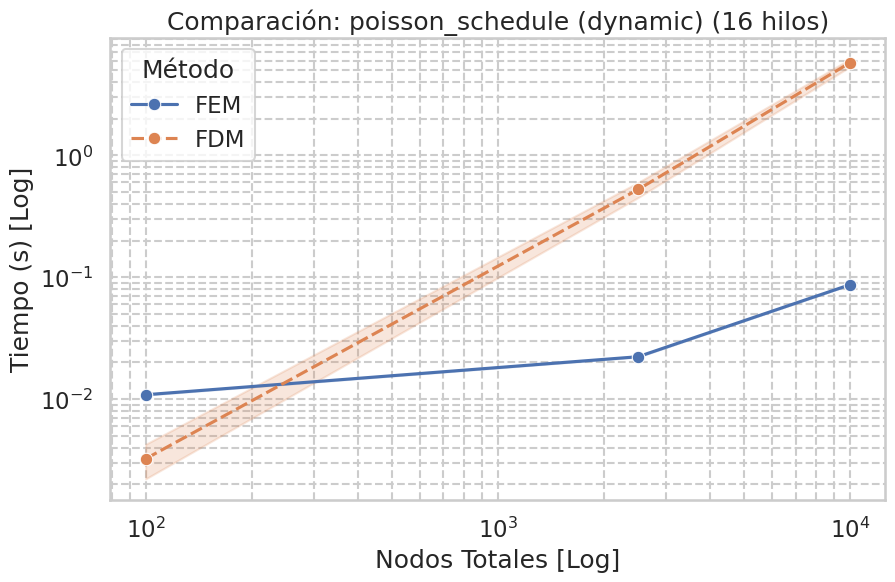

In [2]:
# --- Celda 2: Comparación Directa "Manzana con Manzana" por Versión (Completa) ---

if df_total is not None:
    sns.set_theme(style="whitegrid", context="talk")
    
    # Lista completa de todas las versiones a comparar
    versiones_a_comparar = [
        'poisson_serial', 
        'poisson_parallel', 
        'poisson_collapse', 
        'poisson_sections', 
        'poisson_sincronizacion',
        'poisson_schedule'
    ]
    
    max_hilos = df_total[df_total['hilos'].notna()]['hilos'].max()
    print(f"Comparando versiones paralelas con {int(max_hilos)} hilos.")

    for version in versiones_a_comparar:
        if version == 'poisson_schedule':
            # Para 'schedule', creamos dos gráficas separadas, una para static y otra para dynamic
            for sched_name in ['static', 'dynamic']:
                plt.figure(figsize=(10, 6))
                df_plot = df_total[(df_total['version'] == version) & (df_total['hilos'] == max_hilos) & (df_total['schedule'] == sched_name)]
                title = f'Comparación: {version} ({sched_name}) ({int(max_hilos)} hilos)'
                
                if not df_plot.empty and df_plot.groupby('metodo')['metodo'].count().min() > 0:
                    sns.lineplot(data=df_plot, x='malla_total', y='tiempo', hue='metodo', style='metodo', marker='o')
                    plt.title(title)
                    plt.xlabel('Nodos Totales [Log]'); plt.ylabel('Tiempo (s) [Log]')
                    plt.xscale('log'); plt.yscale('log')
                    plt.legend(title='Método')
                    plt.grid(True, which="both", ls="--")
                    plt.show()
                else:
                    print(f"No hay datos suficientes para comparar '{title}'. Saltando.")
        else:
            # Para las otras versiones
            plt.figure(figsize=(10, 6))
            if version == 'poisson_serial':
                df_plot = df_total[df_total['version'] == version]
                title = f'Comparación de Rendimiento: {version}'
            else:
                df_plot = df_total[(df_total['version'] == version) & (df_total['hilos'] == max_hilos)]
                title = f'Comparación de Rendimiento: {version} ({int(max_hilos)} hilos)'
            
            if not df_plot.empty and df_plot.groupby('metodo')['metodo'].count().min() > 0:
                sns.lineplot(data=df_plot, x='malla_total', y='tiempo', hue='metodo', style='metodo', marker='o')
                plt.title(title)
                plt.xlabel('Nodos Totales [Log]'); plt.ylabel('Tiempo (s) [Log]')
                plt.xscale('log'); plt.yscale('log')
                plt.legend(title='Método')
                plt.grid(True, which="both", ls="--")
                plt.show()
            else:
                print(f"No hay datos suficientes para comparar la versión '{version}'. Saltando.")


--- Rendimiento Promedio General (Paralelo) ---
Calculado con la malla más grande (100x100) y 16 hilos.
  metodo    tiempo
0    FDM  1.662926
1    FEM  0.065976


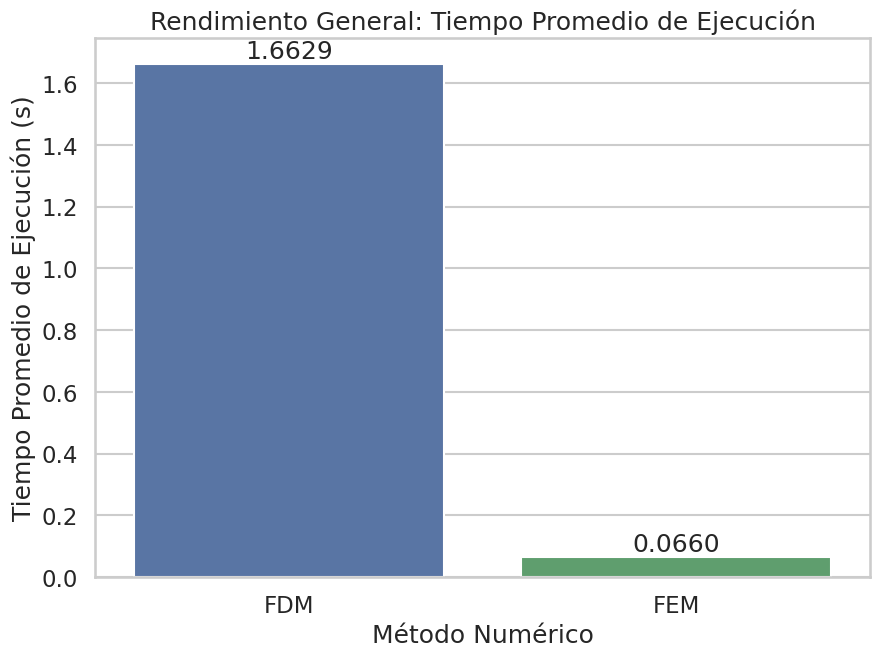

In [3]:
# --- Celda 3: Gráfica de Rendimiento General (Promedio) ---

if 'df_total' in locals() and df_total is not None:
    largest_mesh_m = df_total['malla_M'].max()
    max_hilos = df_total['hilos'].max()
    
    df_agg = df_total[
        (df_total['malla_M'] == largest_mesh_m) &
        (df_total['hilos'] == max_hilos) &
        (~df_total['version'].isin(['poisson_serial', 'poisson_sincronizacion']))
    ]
    df_avg_time = df_agg.groupby('metodo')['tiempo'].mean().reset_index()
    
    print("\n--- Rendimiento Promedio General (Paralelo) ---")
    print(f"Calculado con la malla más grande ({largest_mesh_m}x{largest_mesh_m}) y {int(max_hilos)} hilos.")
    print(df_avg_time)
    
    plt.figure(figsize=(10, 7))
    barplot = sns.barplot(data=df_avg_time, x='metodo', y='tiempo', hue='metodo', palette=['#4c72b0', '#55a868'], dodge=False)
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.title('Rendimiento General: Tiempo Promedio de Ejecución')
    plt.xlabel('Método Numérico'); plt.ylabel('Tiempo Promedio de Ejecución (s)')
    plt.legend([],[], frameon=False)
    plt.show()
else:
    print("La variable 'df_total' no está definida. Ejecuta la Celda 1 primero.")


--- ANÁLISIS DE SPEEDUP Y EFICIENCIA COMPARATIVO ---


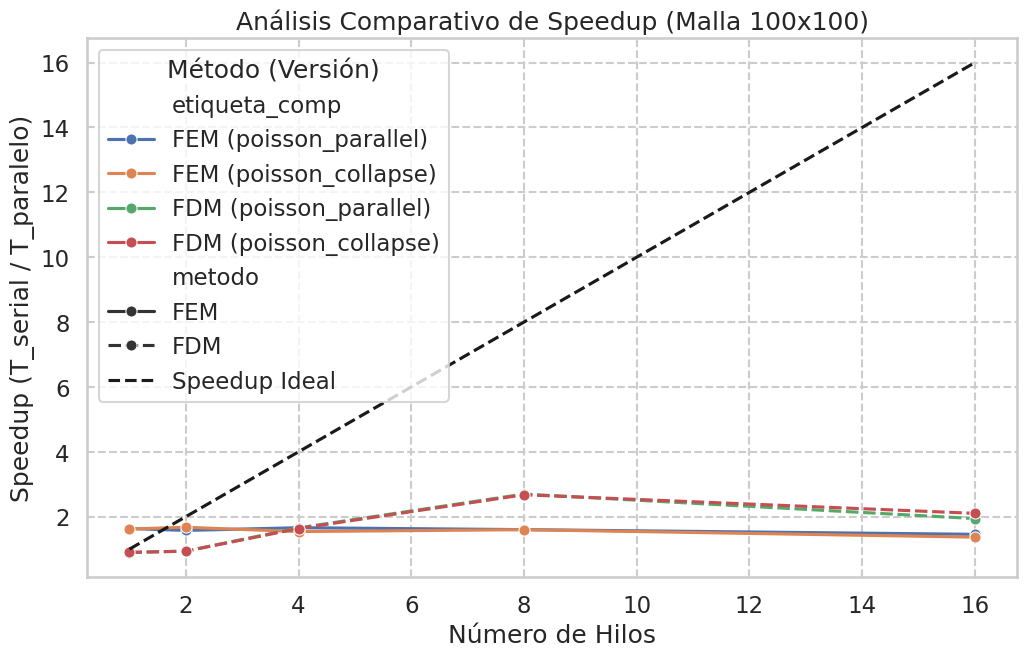

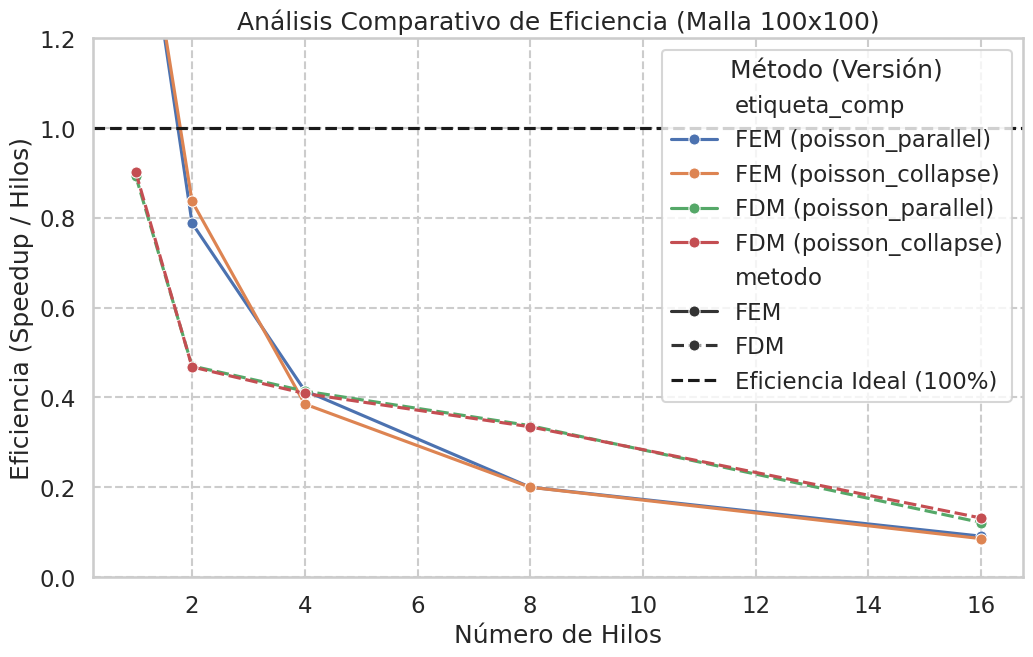

In [4]:
# --- Celda 4: Análisis Comparativo de Speedup y Eficiencia ---

if 'df_total' in locals() and df_total is not None:
    print("\n--- ANÁLISIS DE SPEEDUP Y EFICIENCIA COMPARATIVO ---")
    
    # 1. Filtramos los datos para la malla más grande y el caso 1
    largest_mesh_m = df_total['malla_M'].max()
    df_speedup_base = df_total[(df_total['malla_M'] == largest_mesh_m) & (df_total['caso'] == 1)].copy()
    
    # 2. Obtenemos los tiempos base seriales para cada método
    try:
        t_serial_fem = df_speedup_base[(df_speedup_base['metodo'] == 'FEM') & (df_speedup_base['version'] == 'poisson_serial')]['tiempo'].iloc[0]
        t_serial_fdm = df_speedup_base[(df_speedup_base['metodo'] == 'FDM') & (df_speedup_base['version'] == 'poisson_serial')]['tiempo'].iloc[0]
    except IndexError:
        print("ERROR: No se encontró el tiempo de ejecución serial para uno o ambos métodos. No se puede calcular el Speedup.")
        t_serial_fem = None
        
    if t_serial_fem is not None:
        # 3. Calculamos Speedup y Eficiencia para cada método por separado
        # Para mantener la gráfica limpia, solo compararemos las versiones más representativas
        versiones_escalabilidad = ['poisson_parallel', 'poisson_collapse']
        df_parallel = df_speedup_base[df_speedup_base['version'].isin(versiones_escalabilidad)].copy()
        
        # Función para aplicar el cálculo de speedup
        def calculate_speedup(row):
            if row['metodo'] == 'FEM':
                return t_serial_fem / row['tiempo']
            elif row['metodo'] == 'FDM':
                return t_serial_fdm / row['tiempo']
            return np.nan

        df_parallel['speedup'] = df_parallel.apply(calculate_speedup, axis=1)
        df_parallel['eficiencia'] = df_parallel['speedup'] / df_parallel['hilos']
        
        # Creamos una etiqueta combinada para la leyenda
        df_parallel['etiqueta_comp'] = df_parallel['metodo'] + ' (' + df_parallel['version'] + ')'

        # 4. Graficar Speedup Comparativo
        plt.figure(figsize=(12, 7))
        sns.lineplot(data=df_parallel, x='hilos', y='speedup', hue='etiqueta_comp', style='metodo', marker='o', markersize=8)
        # Línea de speedup ideal
        thread_counts_unique = sorted(df_parallel['hilos'].unique())
        plt.plot(thread_counts_unique, thread_counts_unique, 'k--', label='Speedup Ideal')
        plt.title(f'Análisis Comparativo de Speedup (Malla {largest_mesh_m}x{largest_mesh_m})')
        plt.xlabel('Número de Hilos'); plt.ylabel('Speedup (T_serial / T_paralelo)')
        plt.legend(title='Método (Versión)')
        plt.grid(True, which="both", ls="--")
        plt.show()

        # 5. Graficar Eficiencia Comparativa
        plt.figure(figsize=(12, 7))
        sns.lineplot(data=df_parallel, x='hilos', y='eficiencia', hue='etiqueta_comp', style='metodo', marker='o', markersize=8)
        plt.axhline(y=1.0, color='k', linestyle='--', label='Eficiencia Ideal (100%)')
        plt.title(f'Análisis Comparativo de Eficiencia (Malla {largest_mesh_m}x{largest_mesh_m})')
        plt.xlabel('Número de Hilos'); plt.ylabel('Eficiencia (Speedup / Hilos)')
        plt.ylim(0, 1.2)
        plt.legend(title='Método (Versión)')
        plt.grid(True, which="both", ls="--")
        plt.show()
else:
    print("La variable 'df_total' no está definida. Ejecuta las celdas anteriores primero.")